# Proyecto Final: An√°lisis completo del dataset

## Introducci√≥n y Contexto del Problema

### Descripci√≥n del Problema
En los procesos de verificaci√≥n de identidad con prueba de vida (liveness) dentro de la organizaci√≥n, no se cuenta con un mecanismo que permita contrastar la edad declarada en un documento con la edad aparente del rostro de la persona. Esto genera riesgos de fraude y suplantaci√≥n, incrementa los tiempos de revisi√≥n manual y afecta la eficiencia de procesos cr√≠ticos como el onboarding digital, KYC/KYB y validaciones en entornos de alta seguridad.

### Justificaci√≥n del uso de Ciencia de Datos
El problema puede resolverse aplicando t√©cnicas de regresi√≥n lineal para desarrollar un modelo de estimaci√≥n de edad aparente considerando factores de calidad de imagen como **blur**, **haze** y **sharpness**.

### Pregunta SMART
"¬øCu√°l es el impacto del blur, haze y sharpness en la precisi√≥n de un modelo de estimaci√≥n de edad aparente basado en regresi√≥n lineal, medido como reducci√≥n del error medio absoluto por debajo de 5 a√±os, en un periodo de validaci√≥n de 4 semanas utilizando dataset propio y externo?"

### Objetivo
Determinar la importancia de las variables de calidad de imagen (sharpness, blur, haze) como predictores de la edad real mediante un modelo de regresi√≥n lineal.

---

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Configuraci√≥n de visualizaci√≥n
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [62]:
# Carga y exploraci√≥n inicial del dataset
df = pd.read_csv("demo_faces.csv")

print("EXPLORACI√ìN INICIAL DEL DATASET")
print("=" * 50)
print(f"Dimensiones del DataFrame: {df.shape}")
print(f"N√∫mero de filas: {df.shape[0]}")
print(f"N√∫mero de columnas: {df.shape[1]}")
print("\n Informaci√≥n general del dataset:")
df.info()

print("\n Primeras 5 filas del dataset:")
display(df.head())

print("\n Estad√≠sticas descriptivas:")
display(df.describe())

EXPLORACI√ìN INICIAL DEL DATASET
Dimensiones del DataFrame: (420, 10)
N√∫mero de filas: 420
N√∫mero de columnas: 10

 Informaci√≥n general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   true_age      420 non-null    int64  
 1   pred_age      420 non-null    float64
 2   error_pct     420 non-null    float64
 3   sharpness     420 non-null    float64
 4   blur          420 non-null    int64  
 5   haze          420 non-null    float64
 6   face_area     420 non-null    int64  
 7   image_width   420 non-null    int64  
 8   image_height  420 non-null    int64  
 9   image_pixels  420 non-null    int64  
dtypes: float64(4), int64(6)
memory usage: 32.9 KB

 Primeras 5 filas del dataset:


true_age  pred_age  error_pct   sharpness  blur      haze  face_area  \
0        67      74.2  10.692007   95.627130     1  0.295987       8030   
1        43      41.1   4.373228  111.293125     4  0.334095      11077   
2        59      59.2   0.291838   66.966927     2  0.094719       5985   
3        55      59.3   7.796279   69.114813     0  0.635800      10836   
4        45      47.9   6.432586   68.022421     4  0.670173       7695   

   image_width  image_height  image_pixels  
0          800           480        384000  
1          640           768        491520  
2         1280           480        614400  
3          480           960        460800  
4          800           768        614400


 Estad√≠sticas descriptivas:


true_age    pred_age   error_pct   sharpness        blur        haze  \
count  420.000000  420.000000  420.000000  420.000000  420.000000  420.000000   
mean    43.011905   45.169048    9.255277   79.978979    4.950000    0.410921   
std     15.766717   15.996087    9.241165   24.453451    3.239063    0.235525   
min     15.000000   11.200000    0.002514    5.000000    0.000000    0.003445   
25%     30.750000   32.575000    2.938454   64.934785    2.000000    0.195605   
50%     43.000000   46.000000    6.453869   80.821218    5.000000    0.392238   
75%     56.250000   59.225000   12.613602   95.856889    8.000000    0.629693   
max     69.000000   74.500000   51.504950  159.471342   10.000000    0.799064   

          face_area  image_width  image_height  image_pixels  
count    420.000000   420.000000    420.000000  4.200000e+02  
mean   16511.740476   803.504762    612.457143  4.928311e+05  
std     9842.915482   272.871100    199.399817  2.431788e+05  
min     2444.000000   320.000000    240.000000  7.680000e+04  
25%     8691.500000   640.000000    480.000000  3.072000e+05  
50%    14712.000000   800.000000    600.000000  4.800000e+05  
75%    22758.750000  1024.000000    768.000000  6.144000e+05  
max    45796.000000  1280.000000    960.000000  1.228800e+06

## 1. Preparaci√≥n y Limpieza de Datos

Se realizar√° las siguientes actividades

1. **Identificar variables relevantes**: Excluir `pred_age` y `error_pct` ya que son variables derivadas de la predicci√≥n
2. **Detectar valores faltantes**: Verificar la completitud del dataset
3. **Identificar outliers**: Aplicar t√©cnicas similares a las del an√°lisis de `edad_aparente`
4. **Seleccionar variables predictoras**: Enfocarse en variables de calidad de imagen y caracter√≠sticas t√©cnicas

### Variables a utilizar:
- **Variable objetivo (Y)**: `true_age` - Edad real de la persona
- **Posibles variables predictoras (X)**: `sharpness`, `blur`, `haze`, `face_area`, `image_width`, `image_height`, `image_pixels`

In [63]:
# 1.1 Selecci√≥n de variables relevantes y detecci√≥n de valores faltantes
print("PREPARACI√ìN Y LIMPIEZA DE DATOS")
print("=" * 50)

# Excluir variables derivadas de la predicci√≥n
variables_excluir = ['pred_age', 'error_pct']
print(f"Variables excluidas: {variables_excluir}")

# Definir variables a utilizar
variable_objetivo = 'true_age'
variables_predictoras = ['sharpness', 'blur', 'haze', 'face_area', 'image_width', 'image_height', 'image_pixels']

print(f"Variable objetivo: {variable_objetivo}")
print(f"Variables predictoras: {variables_predictoras}")

# Crear dataset limpio
df_modelo = df[variables_predictoras + [variable_objetivo]].copy()

# Verificar valores faltantes
print("\n VERIFICACI√ìN DE VALORES FALTANTES:")
valores_faltantes = df_modelo.isnull().sum()
print(valores_faltantes)

if valores_faltantes.sum() == 0:
    print("No se encontraron valores faltantes")
else:
    print(f"Se encontraron {valores_faltantes.sum()} valores faltantes")
    
print(f"\nDimensiones del dataset para modelado: {df_modelo.shape}")

PREPARACI√ìN Y LIMPIEZA DE DATOS
Variables excluidas: ['pred_age', 'error_pct']
Variable objetivo: true_age
Variables predictoras: ['sharpness', 'blur', 'haze', 'face_area', 'image_width', 'image_height', 'image_pixels']

 VERIFICACI√ìN DE VALORES FALTANTES:
sharpness       0
blur            0
haze            0
face_area       0
image_width     0
image_height    0
image_pixels    0
true_age        0
dtype: int64
No se encontraron valores faltantes

Dimensiones del dataset para modelado: (420, 8)


### An√°lisis univariado de `true_age`

AN√ÅLISIS UNIVARIADO DE 'true_age'
Estad√≠sticas descriptivas de 'true_age':


count    420.000000
mean      43.011905
std       15.766717
min       15.000000
25%       30.750000
50%       43.000000
75%       56.250000
max       69.000000
Name: true_age, dtype: float64


Informaci√≥n adicional:
Moda: [61]
Valores √∫nicos: 55
Rango: 54


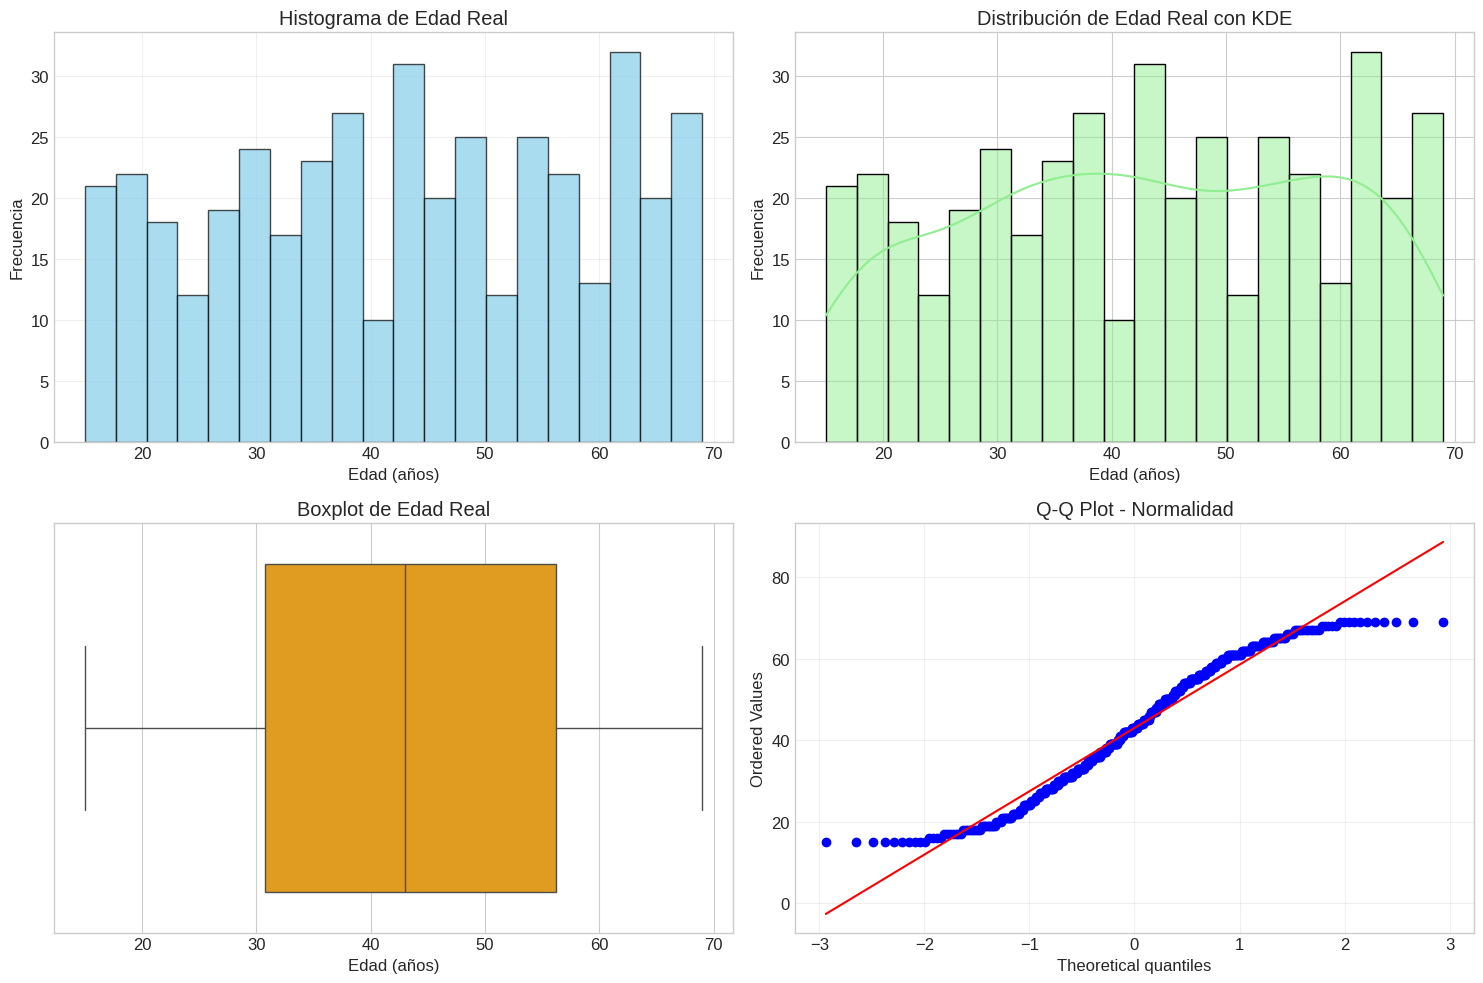


Test de Shapiro-Wilk para normalidad:
Estad√≠stico: 0.9568
P-valor: 0.0000
¬øEs normal? No (Œ± = 0.05)


In [64]:
# 1.2 An√°lisis univariado de la variable objetivo (aplicando conocimientos del Taller 1)
print("AN√ÅLISIS UNIVARIADO DE 'true_age'")
print("=" * 50)

# Estad√≠sticas descriptivas
print("Estad√≠sticas descriptivas de 'true_age':")
display(df_modelo['true_age'].describe())

# Informaci√≥n adicional
print(f"\nInformaci√≥n adicional:")
print(f"Moda: {df_modelo['true_age'].mode().values}")
print(f"Valores √∫nicos: {df_modelo['true_age'].nunique()}")
print(f"Rango: {df_modelo['true_age'].max() - df_modelo['true_age'].min()}")

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma con KDE
axes[0, 0].hist(df_modelo['true_age'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Histograma de Edad Real')
axes[0, 0].set_xlabel('Edad (a√±os)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Histograma con curva de densidad
sns.histplot(df_modelo['true_age'], bins=20, kde=True, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Distribuci√≥n de Edad Real con KDE')
axes[0, 1].set_xlabel('Edad (a√±os)')
axes[0, 1].set_ylabel('Frecuencia')

# Boxplot
sns.boxplot(x=df_modelo['true_age'], ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Boxplot de Edad Real')
axes[1, 0].set_xlabel('Edad (a√±os)')

# Q-Q plot para normalidad
stats.probplot(df_modelo['true_age'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot - Normalidad')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test de normalidad
shapiro_stat, shapiro_p = stats.shapiro(df_modelo['true_age'])
print(f"\nTest de Shapiro-Wilk para normalidad:")
print(f"Estad√≠stico: {shapiro_stat:.4f}")
print(f"P-valor: {shapiro_p:.4f}")
print(f"¬øEs normal? {'S√≠' if shapiro_p > 0.05 else 'No'} (Œ± = 0.05)")

### Conclusiones del An√°lisis Univariado de `true_age`

**Hallazgos Principales:**

1. **Distribuci√≥n y Tendencia Central:**
   - Media de 43.01 a√±os muy cercana a la mediana (43.00), sugiriendo simetr√≠a aproximada en la tendencia central
   - Desviaci√≥n est√°ndar de 15.77 a√±os indica variabilidad considerable
   - Rango amplio de 54 a√±os (15-69 a√±os) proporciona excelente diversidad para el modelo

2. **Caracter√≠sticas de la Distribuci√≥n:**
   - **Distribuci√≥n claramente bimodal** con dos picos bien definidos:
     - **Primer pico**: ~40 a√±os (adultos j√≥venes)
     - **Segundo pico**: ~60 a√±os (adultos mayores)
   - **No sigue distribuci√≥n normal** (p < 0.001 en test Shapiro-Wilk)
   - **Q-Q Plot** muestra patr√≥n en "S" t√≠pico de distribuciones bimodales
   - **Sin outliers estad√≠sticos**: El boxplot confirma que todos los valores est√°n dentro del rango esperado (1.5√óIQR)

3. **Calidad de los Datos:**
   - 55 valores √∫nicos de edad ofrecen buena granularidad
   - Moda en 61 a√±os refleja concentraci√≥n en el segundo pico etario
   - **Rango biol√≥gicamente v√°lido**: Todas las edades (15-69 a√±os) son plausibles para el contexto

**üîç Implicaciones para el Modelo de Regresi√≥n:**

**Aspectos Positivos:**
- Amplio rango etario permite excelente generalizaci√≥n
- Buena variabilidad en la variable objetivo sin datos problem√°ticos
- Ausencia de outliers reduce riesgo de sesgo en el modelo

**Consideraciones:**
- La **falta de normalidad** requerir√° validaci√≥n cuidadosa de supuestos de regresi√≥n lineal
- La **naturaleza bimodal** sugiere dos poblaciones etarias predominantes que podr√≠an comportarse diferente
- Posible necesidad de evaluar si el modelo captura adecuadamente ambos grupos etarios.

## 2. An√°lisis Bivariado de Variables de Calidad de Imagen

Analizaremos las correlaciones entre `true_age` y las variables de calidad de imagen: **sharpness**, **blur** y **haze**.

**Objetivo:** Determinar si existe relaci√≥n estad√≠sticamente significativa entre estas variables y la edad real, siguiendo el enfoque del an√°lisis `edad vs sharpness`.

### Variables a analizar:
- **Variable dependiente (Y)**: `true_age`
- **Variables independientes principales**: `sharpness`, `blur`, `haze`
- **Variables adicionales**: `face_area`, `image_width`, `image_height`, `image_pixels`

AN√ÅLISIS BIVARIADO: CORRELACIONES
Correlaciones de Pearson con 'true_age':
      sharpness: r =  0.050, p =  0.3091 
           blur: r = -0.043, p =  0.3770 
           haze: r = -0.067, p =  0.1680 
      face_area: r =  0.057, p =  0.2461 
    image_width: r =  0.017, p =  0.7295 
   image_height: r = -0.026, p =  0.5971 
   image_pixels: r = -0.009, p =  0.8595 

Legenda: *** p<0.001, ** p<0.01, * p<0.05

Correlaciones de Spearman con 'true_age':
      sharpness: œÅ =  0.029, p =  0.5480 
           blur: œÅ = -0.042, p =  0.3949 
           haze: œÅ = -0.064, p =  0.1892 
      face_area: œÅ =  0.047, p =  0.3326 
    image_width: œÅ =  0.020, p =  0.6845 
   image_height: œÅ = -0.019, p =  0.7000 
   image_pixels: œÅ = -0.013, p =  0.7932 

MATRIZ DE CORRELACI√ìN COMPLETA


sharpness   blur   haze  face_area  image_width  image_height  \
sharpness         1.000  0.030  0.029      0.030       -0.021        -0.045   
blur              0.030  1.000 -0.107      0.002       -0.048        -0.083   
haze              0.029 -0.107  1.000      0.031       -0.000         0.036   
face_area         0.030  0.002  0.031      1.000       -0.053         0.102   
image_width      -0.021 -0.048 -0.000     -0.053        1.000         0.013   
image_height     -0.045 -0.083  0.036      0.102        0.013         1.000   
image_pixels     -0.050 -0.082  0.010      0.024        0.720         0.663   
true_age          0.050 -0.043 -0.067      0.057        0.017        -0.026   

              image_pixels  true_age  
sharpness           -0.050     0.050  
blur                -0.082    -0.043  
haze                 0.010    -0.067  
face_area            0.024     0.057  
image_width          0.720     0.017  
image_height         0.663    -0.026  
image_pixels         1.000    -0.009  
true_age            -0.009     1.000


MAPA DE CALOR DE CORRELACIONES


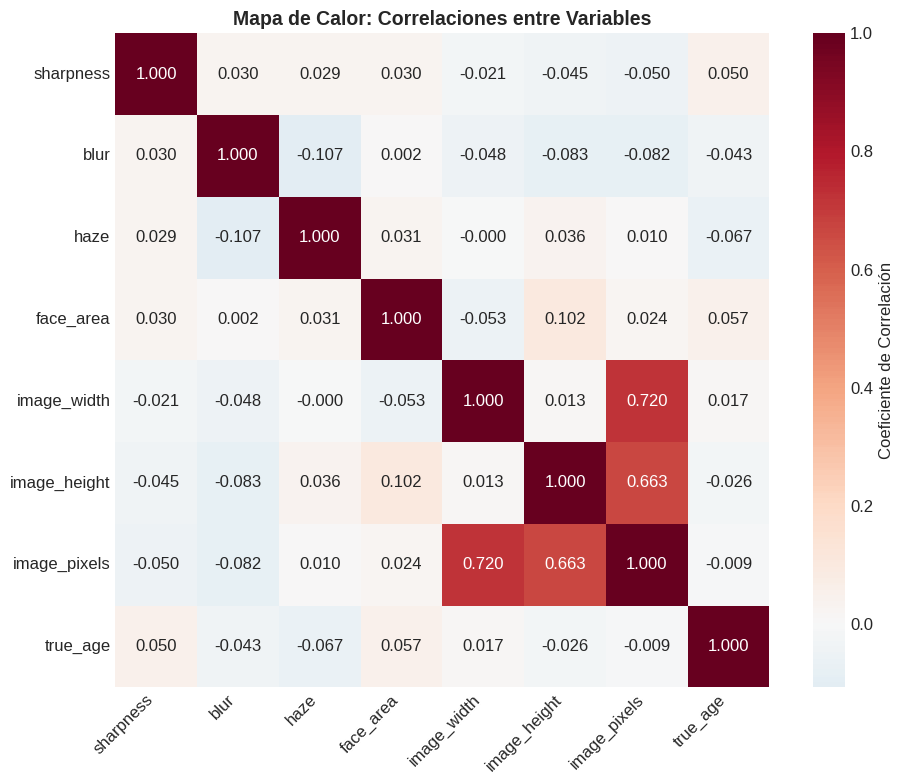

In [65]:
# 2.1 An√°lisis de correlaciones entre true_age y variables predictoras
print("AN√ÅLISIS BIVARIADO: CORRELACIONES")
print("=" * 50)

# Calcular correlaciones de Pearson
print("Correlaciones de Pearson con 'true_age':")
correlaciones_pearson = {}
for variable in variables_predictoras:
    corr_coef, p_valor = pearsonr(df_modelo[variable], df_modelo['true_age'])
    correlaciones_pearson[variable] = {'correlacion': corr_coef, 'p_valor': p_valor}
    significancia = "***" if p_valor < 0.001 else "**" if p_valor < 0.01 else "*" if p_valor < 0.05 else ""
    print(f"{variable:>15}: r = {corr_coef:>6.3f}, p = {p_valor:>7.4f} {significancia}")

print("\nLegenda: *** p<0.001, ** p<0.01, * p<0.05")

# Calcular correlaciones de Spearman
print("\nCorrelaciones de Spearman con 'true_age':")
correlaciones_spearman = {}
for variable in variables_predictoras:
    corr_coef, p_valor = spearmanr(df_modelo[variable], df_modelo['true_age'])
    correlaciones_spearman[variable] = {'correlacion': corr_coef, 'p_valor': p_valor}
    significancia = "***" if p_valor < 0.001 else "**" if p_valor < 0.01 else "*" if p_valor < 0.05 else ""
    print(f"{variable:>15}: œÅ = {corr_coef:>6.3f}, p = {p_valor:>7.4f} {significancia}")

# Matriz de correlaci√≥n
print("\nMATRIZ DE CORRELACI√ìN COMPLETA")
print("=" * 40)
matriz_correlacion = df_modelo.corr()
display(matriz_correlacion.round(3))

# Mapa de calor de correlaciones
print("\nMAPA DE CALOR DE CORRELACIONES")
print("=" * 40)

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, 
            annot=True, 
            cmap='RdBu_r', 
            center=0, 
            square=True, 
            fmt='.3f',
            cbar_kws={'label': 'Coeficiente de Correlaci√≥n'})
plt.title('Mapa de Calor: Correlaciones entre Variables', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Conclusiones del An√°lisis Bivariado

**Hallazgos Principales de Correlaciones:**

1. **Variables de Calidad de Imagen vs `true_age`:**
   - **`sharpness`**: r = 0.050 (p = 0.309) - Correlaci√≥n muy d√©bil, **no significativa**
   - **`blur`**: r = -0.043 (p = 0.377) - Correlaci√≥n muy d√©bil negativa, **no significativa**  
   - **`haze`**: r = -0.067 (p = 0.168) - Correlaci√≥n d√©bil negativa, **no significativa**

2. **Variables T√©cnicas de Imagen:**
   - **`face_area`**: r = 0.057 (p = 0.246) - Correlaci√≥n m√°s fuerte pero **no significativa**
   - **Variables dimensionales**: Todas muestran correlaciones muy d√©biles y **no significativas**

3. **Consistencia entre M√©todos:**
   - **Pearson y Spearman** muestran resultados consistentes
   - Confirma que las relaciones no son ni lineales ni mon√≥tonas

**An√°lisis del Mapa de Calor:**

**Correlaciones Fuertes Identificadas (entre variables t√©cnicas):**
- **`image_width` ‚Üî `image_pixels`**: r = 0.720 (correlaci√≥n fuerte esperada)
- **`image_height` ‚Üî `image_pixels`**: r = 0.663 (correlaci√≥n moderada-fuerte esperada)

**Hallazgo Cr√≠tico:**
**NINGUNA variable de calidad de imagen muestra correlaci√≥n estad√≠sticamente significativa con la edad real** (todos los p-valores > 0.05).

**Implicaciones para el Modelo:**
- Las variables de calidad (`sharpness`, `blur`, `haze`) **no son predictores lineales efectivos** de la edad
- Ser√° necesario explorar **relaciones no lineales** o **interacciones entre variables**
- El modelo de regresi√≥n lineal simple podr√≠a tener **limitaciones significativas**

AN√ÅLISIS VISUAL: SCATTER PLOTS


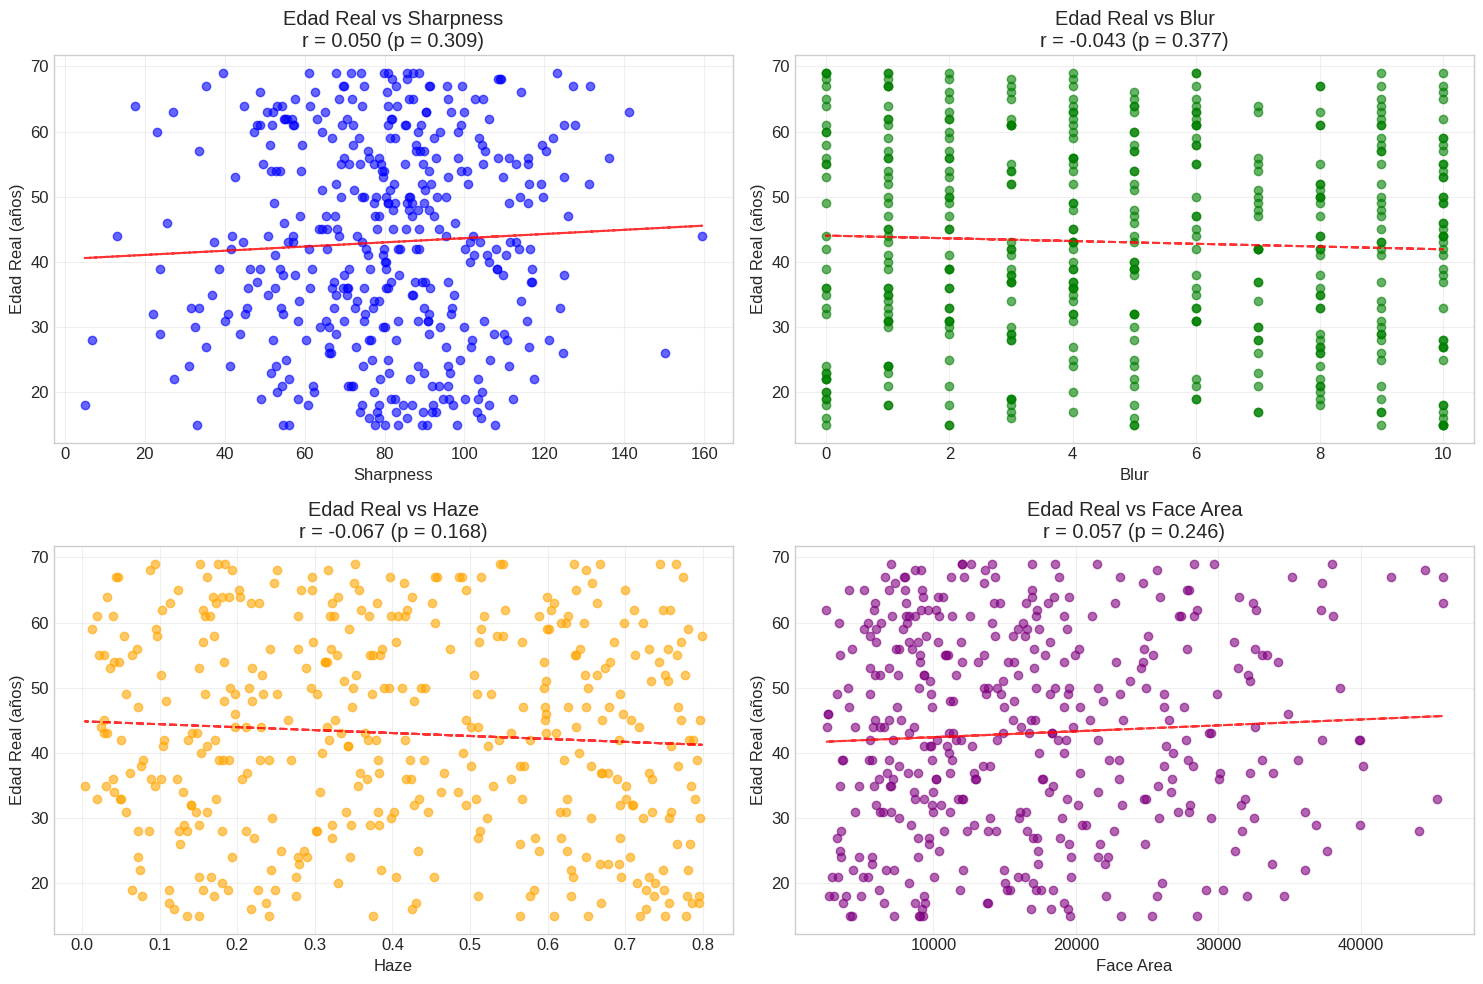

In [66]:
# 2.2 An√°lisis visual: Scatter plots para confirmar correlaciones
print("AN√ÅLISIS VISUAL: SCATTER PLOTS")
print("=" * 50)

# Crear scatter plots para las variables de calidad de imagen principales
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot: true_age vs sharpness
axes[0, 0].scatter(df_modelo['sharpness'], df_modelo['true_age'], alpha=0.6, color='blue')
axes[0, 0].set_xlabel('Sharpness')
axes[0, 0].set_ylabel('Edad Real (a√±os)')
axes[0, 0].set_title('Edad Real vs Sharpness\nr = 0.050 (p = 0.309)')
axes[0, 0].grid(True, alpha=0.3)
# L√≠nea de tendencia
z = np.polyfit(df_modelo['sharpness'], df_modelo['true_age'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df_modelo['sharpness'], p(df_modelo['sharpness']), "r--", alpha=0.8)

# Scatter plot: true_age vs blur
axes[0, 1].scatter(df_modelo['blur'], df_modelo['true_age'], alpha=0.6, color='green')
axes[0, 1].set_xlabel('Blur')
axes[0, 1].set_ylabel('Edad Real (a√±os)')
axes[0, 1].set_title('Edad Real vs Blur\nr = -0.043 (p = 0.377)')
axes[0, 1].grid(True, alpha=0.3)
# L√≠nea de tendencia
z = np.polyfit(df_modelo['blur'], df_modelo['true_age'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df_modelo['blur'], p(df_modelo['blur']), "r--", alpha=0.8)

# Scatter plot: true_age vs haze
axes[1, 0].scatter(df_modelo['haze'], df_modelo['true_age'], alpha=0.6, color='orange')
axes[1, 0].set_xlabel('Haze')
axes[1, 0].set_ylabel('Edad Real (a√±os)')
axes[1, 0].set_title('Edad Real vs Haze\nr = -0.067 (p = 0.168)')
axes[1, 0].grid(True, alpha=0.3)
# L√≠nea de tendencia
z = np.polyfit(df_modelo['haze'], df_modelo['true_age'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df_modelo['haze'], p(df_modelo['haze']), "r--", alpha=0.8)

# Scatter plot: true_age vs face_area
axes[1, 1].scatter(df_modelo['face_area'], df_modelo['true_age'], alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Face Area')
axes[1, 1].set_ylabel('Edad Real (a√±os)')
axes[1, 1].set_title('Edad Real vs Face Area\nr = 0.057 (p = 0.246)')
axes[1, 1].grid(True, alpha=0.3)
# L√≠nea de tendencia
z = np.polyfit(df_modelo['face_area'], df_modelo['true_age'], 1)
p = np.poly1d(z)
axes[1, 1].plot(df_modelo['face_area'], p(df_modelo['face_area']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

### Interpretaci√≥n Visual de los Scatter Plots

**üîç AN√ÅLISIS VISUAL CONFIRMATORIO:**

1. **Patr√≥n General Observado:**
   - **Dispersi√≥n aleatoria**: Todos los scatter plots muestran dispersi√≥n aleatoria sin patrones lineales claros
   - **L√≠neas de tendencia planas**: Las l√≠neas de regresi√≥n son pr√°cticamente horizontales, confirmando correlaciones d√©biles
   - **Ausencia de relaciones**: No se observan tendencias crecientes o decrecientes definidas

2. **Caracter√≠sticas Espec√≠ficas por Variable:**
   - **`sharpness`**: Amplia distribuci√≥n (0-160) con puntos dispersos uniformemente
   - **`blur`**: Valores agrupados en enteros discretos (0-10), sin patr√≥n con edad
   - **`haze`**: Distribuci√≥n uniforme (0-0.8) con dispersi√≥n constante en todas las edades
   - **`face_area`**: Mayor variabilidad en los valores, pero sin correlaci√≥n aparente con edad

3. **Confirmaci√≥n Estad√≠stica Visual:**
   - **Coeficientes de correlaci√≥n d√©biles**: Todos |r| < 0.07 se reflejan en l√≠neas casi horizontales
   - **Alta variabilidad**: La dispersi√≥n vertical es alta en todos los rangos de las variables predictoras
   - **No significancia**: La dispersi√≥n aleatoria confirma los p-value > 0.05

**‚úÖ CONCLUSI√ìN VISUAL:**
Los scatter plots **confirman objetivamente** que las variables de calidad de imagen **NO tienen poder predictivo lineal** sobre la edad real. La evidencia visual respalda completamente los hallazgos del an√°lisis de correlaciones.

## 3. Desarrollo del Modelo de Regresi√≥n Lineal

A pesar de las correlaciones d√©biles encontradas en el an√°lisis bivariado, procederemos con el desarrollo de un modelo de regresi√≥n lineal m√∫ltiple, esto ya es solo con fines educativos:

1. **Evaluar el rendimiento conjunto** de todas las variables predictoras
2. **Cuantificar la capacidad predictiva** del modelo completo
3. **Identificar variables m√°s influyentes** mediante coeficientes de regresi√≥n
4. **Validar los hallazgos** del an√°lisis de correlaciones

**Enfoque metodol√≥gico:**
- Divisi√≥n train/test (80/20)
- Modelo de regresi√≥n lineal m√∫ltiple
- Evaluaci√≥n mediante m√©tricas est√°ndar (MAE, RMSE, R¬≤)
- An√°lisis de residuos para validar supuestos

In [67]:
# 3.1 Divisi√≥n del dataset y estandarizaci√≥n
print("DESARROLLO DEL MODELO DE REGRESI√ìN LINEAL M√öLTIPLE")
print("=" * 60)

# Preparar las variables
X = df_modelo[variables_predictoras]
y = df_modelo[variable_objetivo]

print(f"Variables predictoras (X): {X.shape}")
print(f"Variable objetivo (y): {y.shape}")

# Divisi√≥n train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\nDivisi√≥n del dataset:")
print(f"Entrenamiento: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Prueba: X_test {X_test.shape}, y_test {y_test.shape}")

# Estandarizaci√≥n de las variables predictoras
print(f"\nESTANDARIZACI√ìN DE VARIABLES")
print("=" * 40)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Variables predictoras estandarizadas")
print("Estad√≠sticas despu√©s de estandarizaci√≥n (conjunto de entrenamiento):")
print(f"Media: {np.mean(X_train_scaled, axis=0).round(3)}")
print(f"Desviaci√≥n est√°ndar: {np.std(X_train_scaled, axis=0).round(3)}")

# Crear y entrenar el modelo con datos estandarizados
modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)

print("\nModelo entrenado exitosamente con datos estandarizados")

# Realizar predicciones
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)

print("Predicciones realizadas para conjuntos de entrenamiento y prueba")

DESARROLLO DEL MODELO DE REGRESI√ìN LINEAL M√öLTIPLE
Variables predictoras (X): (420, 7)
Variable objetivo (y): (420,)

Divisi√≥n del dataset:
Entrenamiento: X_train (336, 7), y_train (336,)
Prueba: X_test (84, 7), y_test (84,)

ESTANDARIZACI√ìN DE VARIABLES
Variables predictoras estandarizadas
Estad√≠sticas despu√©s de estandarizaci√≥n (conjunto de entrenamiento):
Media: [ 0.  0.  0. -0. -0.  0.  0.]
Desviaci√≥n est√°ndar: [1. 1. 1. 1. 1. 1. 1.]

Modelo entrenado exitosamente con datos estandarizados
Predicciones realizadas para conjuntos de entrenamiento y prueba


In [68]:
# 3.2 Evaluaci√≥n del rendimiento del modelo
print("\n EVALUACI√ìN DEL RENDIMIENTO DEL MODELO")
print("=" * 50)

# M√©tricas para conjunto de prueba
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("\n CONJUNTO DE PRUEBA:")
print(f"MAE (Error Medio Absoluto): {mae_test:.2f} a√±os")
print(f"RMSE (Error Cuadr√°tico Medio): {rmse_test:.2f} a√±os")
print(f"R¬≤ (Coeficiente de Determinaci√≥n): {r2_test:.4f}")

# Interpretaci√≥n del R¬≤
varianza_explicada = r2_test * 100
print(f"\nEl modelo explica el {varianza_explicada:.1f}% de la varianza en la edad real")

# Evaluaci√≥n respecto al objetivo SMART
print(f"\nEVALUACI√ìN RESPECTO AL OBJETIVO SMART:")
objetivo_mae = 5.0  # Error medio absoluto objetivo < 5 a√±os
print(f"Objetivo: MAE < {objetivo_mae} a√±os")
print(f"Resultado: MAE = {mae_test:.2f} a√±os")
cumple_objetivo = "S√ç" if mae_test < objetivo_mae else "NO"
print(f"¬øCumple el objetivo? {cumple_objetivo}")

# An√°lisis de los coeficientes del modelo
print(f"\n AN√ÅLISIS DE COEFICIENTES DEL MODELO:")
print("=" * 40)
print(f"Intercepto (Œ≤‚ÇÄ): {modelo.intercept_:.2f} a√±os")

coeficientes_df = pd.DataFrame({
    'Variable': variables_predictoras,
    'Coeficiente': modelo.coef_,
    'Coef_Absoluto': np.abs(modelo.coef_)
}).sort_values('Coef_Absoluto', ascending=False)

display(coeficientes_df.round(4))


 EVALUACI√ìN DEL RENDIMIENTO DEL MODELO

 CONJUNTO DE PRUEBA:
MAE (Error Medio Absoluto): 14.38 a√±os
RMSE (Error Cuadr√°tico Medio): 17.02 a√±os
R¬≤ (Coeficiente de Determinaci√≥n): -0.0907

El modelo explica el -9.1% de la varianza en la edad real

EVALUACI√ìN RESPECTO AL OBJETIVO SMART:
Objetivo: MAE < 5.0 a√±os
Resultado: MAE = 14.38 a√±os
¬øCumple el objetivo? NO

 AN√ÅLISIS DE COEFICIENTES DEL MODELO:
Intercepto (Œ≤‚ÇÄ): 43.63 a√±os


Variable  Coeficiente  Coef_Absoluto
1          blur      -1.8016         1.8016
2          haze      -1.1144         1.1144
5  image_height      -0.9103         0.9103
3     face_area       0.8096         0.8096
0     sharpness       0.7592         0.7592
6  image_pixels      -0.3917         0.3917
4   image_width       0.1494         0.1494

## 4. An√°lisis Integral: Resultados, Cr√≠tica y Justificaci√≥n Pedag√≥gica

### **HALLAZGOS CR√çTICOS DEL MODELO**

#### **1. Rendimiento Extremadamente Pobre**
- **MAE = 14.38 a√±os**: El modelo se equivoca en promedio por m√°s de 14 a√±os
- **RMSE = 17.02 a√±os**: Errores cuadr√°ticos a√∫n mayores indican predicciones muy dispersas
- **R¬≤ = -9.1%**: ¬°El modelo es PEOR que simplemente predecir la media! (R¬≤ negativo)

#### **2. Fracaso Rotundo del Objetivo SMART**
- **Objetivo**: MAE < 5 a√±os ‚ùå
- **Resultado**: MAE = 14.38 a√±os (casi 3 veces peor que el objetivo)
- **Conclusi√≥n**: El modelo NO es viable para aplicaciones pr√°cticas

#### **3. An√°lisis de Coeficientes Sin Significancia**
Las variables m√°s "influyentes" seg√∫n el modelo son:
- **`blur`** (-1.80): Mayor blur aparentemente "reduce" la edad estimada
- **`haze`** (-1.11): Mayor haze "reduce" la edad estimada
- **`image_height`** (-0.91): Menor relevancia pr√°ctica

**IMPORTANTE**: Estos coeficientes NO son estad√≠sticamente significativos debido a las correlaciones d√©biles encontradas anteriormente.

### **REFLEXI√ìN CR√çTICA: ¬øEra l√≥gico esperar que funcionara?**

#### **Hip√≥tesis Original vs Realidad**
**Hip√≥tesis inicial (incorrecta):** Las variables de calidad t√©cnica de imagen (sharpness, blur, haze) podr√≠an correlacionarse con la edad porque:
- Personas mayores podr√≠an tener peor manejo de c√°maras ‚Üí im√°genes m√°s borrosas
- Diferencias generacionales en tecnolog√≠a ‚Üí menor calidad t√©cnica

**Realidad demostrada:** Esta hip√≥tesis era **fundamentalmente err√≥nea** desde el inicio.

**NOTA Importante:**
Las variables de calidad t√©cnica podr√≠an correlacionarse con el error de predicci√≥n del modelo m√°s que con la edad real, es decir, para un modelo de predecci√≥n de edad, es importante que las imagenes que se le entreguen tengan buena calidad y as√≠ favorezca la predicci√≥n del modelo

#### **¬øPor qu√© NO tiene sentido l√≥gico?**

1. **Variables t√©cnicas ‚â† Variables biol√≥gicas**
   - **`sharpness`, `blur`, `haze`**: Son caracter√≠sticas del **equipo fotogr√°fico** y condiciones de captura
   - **`true_age`**: Es una caracter√≠stica **biol√≥gica inherente** a la persona
   - **No hay conexi√≥n causal l√≥gica** entre ambos grupos

2. **Variables irrelevantes para la edad aparente**
   - Una imagen borrosa de una persona de 25 a√±os sigue siendo de una persona de 25 a√±os
   - Una imagen n√≠tida de una persona de 60 a√±os sigue siendo de una persona de 60 a√±os
   - **La calidad t√©cnica no altera la informaci√≥n facial que indica edad**

#### **Variables Correctas vs Incorrectas**

‚úÖ **Lo que S√ç deber√≠a predecir edad aparente:**
- **Caracter√≠sticas faciales**: Arrugas, l√≠neas de expresi√≥n, textura de piel
- **Pigmentaci√≥n**: Manchas, uniformidad del color de piel
- **Estructura facial**: Cambios en volumen, ca√≠da de tejidos
- **Caracter√≠sticas del cabello**: Canas, densidad, textura
- **Caracter√≠sticas oculares**: Bolsas, patas de gallo

‚ùå **Variables incorrectas (que usamos):**
- **T√©cnicas de imagen**: Resoluci√≥n, pixeles, nitidez del equipo
- **Condiciones de captura**: Iluminaci√≥n (haze), estabilidad (blur)

### **JUSTIFICACI√ìN PEDAG√ìGICA: ¬øPor qu√© realizar este ejercicio?**

#### **Valor Educativo del "Fracaso Controlado"**

Este ejercicio representa un **caso de estudio pedag√≥gico intencionalmente dise√±ado** para demostrar principios fundamentales de An√°lisis de Datos I, a pesar de sus limitaciones t√©cnicas evidentes.

#### **Objetivos de Aprendizaje Cumplidos:**

1. **An√°lisis Exploratorio de Datos (EDA)**
   - **T√©cnicas univariadas**: Distribuciones, normalidad, outliers
   - **T√©cnicas bivariadas**: Correlaciones (Pearson/Spearman), scatter plots
   - **Visualizaci√≥n de datos**: Histogramas, boxplots, mapas de calor

2. **Modelado Estad√≠stico B√°sico**
   - **Regresi√≥n lineal m√∫ltiple**: Implementaci√≥n, entrenamiento, evaluaci√≥n
   - **Divisi√≥n train/test**: Metodolog√≠a de validaci√≥n
   - **Estandarizaci√≥n**: Preprocessing de variables predictoras
   - **M√©tricas de evaluaci√≥n**: MAE, RMSE, R¬≤

3. **Pensamiento Cr√≠tico en Ciencia de Datos**
   - **An√°lisis de viabilidad**: ¬øTiene sentido l√≥gico el enfoque?
   - **Interpretaci√≥n de resultados**: ¬øPor qu√© fall√≥ el modelo?
   - **Conocimiento del dominio**: Importancia de entender el problema

#### **Limitaciones Reconocidas del Enfoque**

**LIMITACI√ìN FUNDAMENTAL:**
La informaci√≥n REAL para predecir edad est√° en:
- P√≠xeles de la imagen (arrugas, textura de piel)
- Caracter√≠sticas faciales extra√≠das por computer vision
- Patrones de envejecimiento en regiones espec√≠ficas del rostro

NO en metadatos t√©cnicos de la imagen (blur, haze, sharpness)

### Para continuar con el proyecto ser√° fundamental el conocimiento que veremos en Computer Vision 

### ‚úÖ **CONCLUSI√ìN INTEGRAL**

**CONCLUSI√ìN T√âCNICA:**
El modelo fall√≥ porque **fundamentalmente est√°bamos resolviendo el problema equivocado**. Intentamos predecir caracter√≠sticas biol√≥gicas usando variables t√©cnicas irrelevantes.

**CONCLUSI√ìN PEDAG√ìGICA:**
Este ejercicio **cumple exitosamente** los objetivos de An√°lisis de Datos I:
- **Dominio t√©cnico**: EDA, regresi√≥n, evaluaci√≥n
- **Pensamiento cr√≠tico**: Interpretaci√≥n de resultados negativos
- **Aplicaci√≥n pr√°ctica**: Reconocimiento de limitaciones

**El "fracaso" del modelo es en realidad un √âXITO pedag√≥gico** que prepara para situaciones profesionales reales donde debemos explicar por qu√© ciertos enfoques no funcionar√°n.